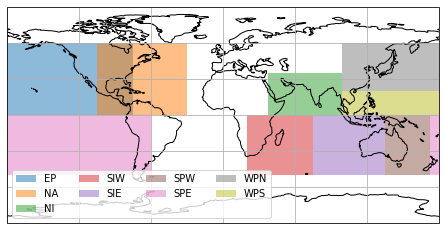

In [1]:
####################### import basic modules #################################
import os
import copy
import netCDF4 as nc
import numpy as np
import xarray as xr
import pandas as pd
import scipy.sparse as sp
from datetime import datetime as dt
from collections import Counter
import datetime
from climada.hazard import Hazard
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

# import modules required for ploting:
import matplotlib.pyplot as plt

# import CLIMADA modules:
from climada.util.constants import SYSTEM_DIR
from climada.hazard import TCTracks, Centroids, TropCyclone

MIT_DIR = "/Users/szelie/OneDrive - ETH Zurich/data/MIT_windfields/windfields"

MIT_STR = "%s_rcp%02d_%s_100.csv"

GCM = ['GFDL-ESM2M', 'HadGEM2-ES', 'IPSL-CM5A-LR', 'MIROC5'] # MIT tracks

MAX_VAL = 1e11 # max. value for cotbour plot
MIN_VAL = 2e2 # min. value
BUFFER_DEG_LON = .5 # map buffer
BUFFER_DEG_LAT = .5

BASIN_BOUNDS = {
    # Eastern Pacific Basin
    'EP': [-180.0, -75.0, 0.0, 60.0],

    # North Atlantic Basin
    'NA': [-105.0, -30.0, 0.0, 60.0],

    # Northern Indian Basin
    'NI': [37.0, 99.0, 0.0, 35.0],

    # Southern Indian Basin
    'SIW': [20.0, 75.0, -50.0, 0.0],
    'SIE': [75.0, 135.0, -50.0, 0.0],

    # Southern Pacific Basin
    'SPW': [135.0, 172.0, -50.0, 0.0],
    'SPE': [172.0, -60.0, -50.0, 0.0],

    # Western Pacific Basin
    'WPN': [99.0, 180.0, 20.0, 60.0],
    'WPS': [99.0, 180.0, 0.0, 20.0],
}

ax = plt.gcf().add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
patches = []
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i, basin in enumerate(BASIN_BOUNDS.keys()):
    lonmin, lonmax, latmin, latmax = BASIN_BOUNDS[basin]
    height = latmax - latmin
    if lonmax >= lonmin:
        width = lonmax - lonmin
    else:
        # basin crossing the -180/180 longitude threshold
        width = (180 - lonmin) + (lonmax - (-180))

    ax.set_global()
    p = mpatches.Rectangle(xy=[lonmin, latmin], width=width, height=height,
                           facecolor=colors[i],
                           alpha=0.5,
                           transform=ccrs.PlateCarree(),
                           label=basin,)
    ax.add_patch(p)
    patches.append(p)
ax.legend(ncol=4, loc='lower left')
ax.gridlines()
ax.coastlines()
plt.show()




def haz_select_bounds(haz, bounds):
    lonmin, lonmax, latmin, latmax = bounds
    lat, lon = haz.centroids.lat, haz.centroids.lon
    if lonmin < lonmax:
        haz.centroids.region_id = (latmin <= lat) & (lat <= latmax) \
                                & (lonmin <= lon) & (lon <= lonmax)
    else:
        # basin crossing the -180/180 longitude threshold
        haz.centroids.region_id = (latmin <= lat) & (lat <= latmax) \
                                & ((lonmin <= lon) | (lon <= lonmax))
    return haz.select(reg_id=1)

def load_tc_realization(path, year_start, year_end, real_id=0, basin=None, n_realisations=10):
    draws = pd.read_csv(path)
    draws = draws[(year_start <= draws['year']) & (draws['year'] <= year_end)]
    #draws = draws.sample(n=n_realisations,axis='rows')
    #draws = draws[draws['real_id'] == real_id].reset_index(drop=True)
    nevents = draws.shape[0]

    # load master hazard object containing all relevant Emanuel tracks
    filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
    master_hazard = TropCyclone()
    hazards = []
    for fname in filenames:
        path = os.path.join(MIT_DIR, fname)
        haz = TropCyclone.from_mat(path)
        haz.event_name = [f"{fname}-{n}" for n in haz.event_name]
        if basin is not None:
            haz = haz_select_bounds(haz, BASIN_BOUNDS[basin])
            haz.basin = [basin]*len(haz.event_name)
        hazards.append(haz)
    master_hazard = master_hazard.concat(hazards)
    
    event_names = list(draws['name'].values)
    hazard = master_hazard.select(event_names=event_names)
    hazard.event_name = [f"{n}-{i}" for n, i in zip(hazard.event_name, draws['real_id'].values)]
    
    years = [dt.fromordinal(d).year for d in hazard.date]
    date_diff = [dt(y_dst, 1, 1).toordinal() - dt(y, 1, 1).toordinal() \
                 for y_dst, y in zip(draws['year'].values, years)]
    hazard.date += date_diff
    
    hazard.check()
    return hazard


# calculate hazard for MIT tracks and store them in the hazard_dict

#GCM = ['MIROC5']    
def make_tc_hazard(basins, rcp, year_start, year_end, draws):

        haz_list = []
        event_name_list = []
        for g, gcm in enumerate(GCM):
            for basin in basins:
                path = os.path.join(MIT_DIR, 'draws', MIT_STR %(GCM[g], RCP[r], basin))
                haz= load_tc_realization(path, basin=basin, year_start=year_start,year_end=year_end, n_realisations=draws)
                haz_list.append(haz)
                draw = [e.split('-')[-1] for e in haz.event_name]
                event_name = ["".join([str(datetime.date.fromordinal(np.min(date)).year), '_', gcm.lower()]) for date in haz.date]
                event_name = ["".join([event_name[n],"_",draw[n]]) for n in range(len(event_name))]
                event_name_list.append(event_name)
        hazard = Hazard.concat(haz_list)
        hazard = hazard.select(extent=(-178,178,-90,90))
        hazard.event_name = list(np.concatenate(event_name_list))

        hazard.write_hdf5("".join(["/Users/szelie/OneDrive - ETH Zurich/data/MIT_windfields/hazards/",basin, '_', str(year_start),"_",str(year_end),"_rcp",str(rcp),".hdf5"]))    
        return hazard



In [ ]:
basins = {'IND':'NI', 'MOZ':'SIW', 'DOM':'NA', 'MEX':'SPW', 'TWN':'WPS'}



## Read in all tracks sets (for 4 GCMs, 2 RCPS)

In [2]:
# calculate hazard for MIT tracks and store them in the hazard_dict
basins = list(BASIN_BOUNDS.keys())

RCP = [26]
years = [2010,2030,2050,2070]
#basins = list(BASIN_BOUNDS.keys())

basins = list(BASIN_BOUNDS.keys())

for basin in basins:
    for r, rcp in enumerate(RCP):
        for years in [2010, 2030, 2050, 2070]:
            make_tc_hazard([basin], rcp, years, years+20, 0)  




/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7

/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7

/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7

/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7

/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_6859/1663460074.py:106: FutureWarning: The default value of regex will change from True to False in a future version.
  filenames = np.unique(draws['name'].str.replace("-[0-9]+$",""))
/var/folders/f5/lms0b90j1kx7

In [8]:
from climada.hazard import TCTracks, Centroids, TropCyclone


tc = TropCyclone.from_mat('/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data/MIT_windfields/windfields/Trial1_GB_dkgfdl_rcp60cal_N_0360as.mat')